# P5


In [6]:
import pandas as pd
import numpy as np

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')


In [7]:
# comment out if don't want to run the preparation notebook
# %run data_process.ipynb

In [8]:
with open('docs_reduced_body', 'rb') as f:
    docs_reduced_body = pickle.load(f)
    f.close()
with open('docs_reduced_body_sentences', 'rb') as f:
    docs_reduced_body_sentences = pickle.load(f)
    f.close()

with open('docs_tags', 'rb') as f:
    docs_tags = pickle.load(f)
    f.close()

with open('common_words', 'rb') as f:
    common_words = pickle.load(f)
    f.close()

with open('common_tags', 'rb') as f:
    common_tags = pickle.load(f)
    f.close()


## MultiLabel Binarizer

### Tags

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_t = MultiLabelBinarizer()
mlb_b = MultiLabelBinarizer()

def mlb_tags():
    # fit the mlb with common tags (200)
    print(f'fitting multilabel binarizer for common tags (len: {len(common_tags)})')
    mlb_t.fit([common_tags])
    print(mlb_t.classes_.shape)
    # docs['mlb_tags'] = mlb_t.transform(docs.tags).tolist()
    return mlb_t

def mlb_body():
    print(f'fitting multilabel binarizer for corpus common words (len: {len(common_words)})')
    mlb_b.fit([common_words])
    print(mlb_b.classes_.shape)
    # docs['mlb_reduced_body'] = mlb_b.transform(docs.reduced_body).tolist()
    return mlb_b
 
mlb_tags()
mlb_body()


fitting multilabel binarizer for common tags (len: 200)
(200,)


MultiLabelBinarizer()

fitting multilabel binarizer for corpus common words (len: 2066)
(2066,)


MultiLabelBinarizer()

In [10]:
# test mlb on body
test_str = 'java'
mlb_b.inverse_transform(mlb_b.transform([[test_str]]))

[('java',)]

In [11]:
docs_body_mlb = [mlb_b.transform([doc])[0] for doc in docs_reduced_body]

In [12]:

docs_tags_mlb = [mlb_t.transform([tag])[0] for tag in docs_tags]

In [13]:
text = docs_reduced_body[0]
# text

transform = mlb_b.inverse_transform(mlb_b.transform([text]))[0]
# transform

assert (text == transform[0]).sum() > 1
assert len(transform) <= len(text)

In [14]:
len(np.unique(docs_reduced_body[0]))
np.count_nonzero(docs_body_mlb[0] == 1)


45

45

In [15]:
# test mlb on tags
tags = docs_tags[0]
tags
transformed_tags = mlb_t.transform([tags])
transformed_tags
assert mlb_t.inverse_transform(transformed_tags)[0][0] == tags[0]

['javascript']

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [16]:
with open('mlb_t', 'wb') as v :
    pickle.dump(mlb_t, v)

## Bag Of Words

Bag of words uses CountVectorizer, then we look for the most frequent word to suggest a tag

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(vocabulary=common_words, ngram_range=(1,2))
bow = cv.fit_transform(docs_reduced_body_sentences)
data_dense = bow.todense()
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsity:  1.7462819410072161 %


In [18]:

len(bow.toarray()[0])
np.count_nonzero(bow[0].toarray() > 2)
cv.get_feature_names_out()

2066

2

array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype=object)

In [19]:
with open('cv', 'wb') as v :
    pickle.dump(cv, v)

## Train, Test Sets

In [20]:
from sklearn.model_selection import train_test_split


X = bow
y = docs_tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



## Scoring Function

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def scoring(y_true, y_pred):
    print(f'accuracy: {np.round(accuracy_score(y_true, y_pred), 2)}')
    print(f'precision: {np.round(precision_score(y_true, y_pred, average="macro"), 2)}')
    print(f'recall: {np.round(recall_score(y_true, y_pred, average="macro"), 2)}')
    print(f'f1-score: {np.round(f1_score(y_true, y_pred, average="macro"), 2)}')
    # print(classification_report(y_true, y_pred, target_names=mlb_t.classes_))


In [22]:
from sklearn.metrics import multilabel_confusion_matrix

def confusion_matrix(y_true, y_pred):
    matrix = multilabel_confusion_matrix(y_true, y_pred, samplewise=False)
    for idx, label in enumerate(mlb_t.classes_):
        print(f'{label} :\n TN:{matrix[idx][0,0]}\tFN:{matrix[idx][1,0]}\tTP:{matrix[idx][1,1]}\tFP:{matrix[idx][0,1]}')

## Dummy Classifier

In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)


DummyClassifier(strategy='most_frequent')

0.02899619117827743

In [24]:
y_true = mlb_t.transform(y_test).tolist()
y_pred = mlb_t.transform(dummy_clf.predict(X_test))

scoring(y_true, y_pred)


accuracy: 1.0
precision: 0.0
recall: 0.0
f1-score: 0.0


## Tf/IdF

Tf-idf takes the frequency of a word from a sentence in a context of a corpus, then we take the most frequent words to suggest a tag

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=common_words, ngram_range=(1, 2))
# vectorizer.fit(docs.reduced_body)
vectorizer.fit(docs_reduced_body_sentences)

vectorizer.get_feature_names_out()


TfidfVectorizer(ngram_range=(1, 2),
                vocabulary=array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype='<U22'))

array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype=object)

In [26]:
with open('vectorizer', 'wb') as v :
    pickle.dump(vectorizer, v)


#### Prediction method for tf-idf

In [27]:
# predicition - nouvelle methode
# TODO optimize  - temps de calcul trop long ~ 3'30

def predict_tfidf(doc, filter_tags=True) -> list[str]:
    """
    Returns a list of tags representative to the document provided, predicted from tf-idf

    Parameters
    ----------
    doc: iterable
        a list of words to compute tf-idf
    
    filter_tags: boolean
        defines if returned tags must be part of a currated list of tags
    
    Returns
    -------
    ret : a list of strings, may be empty

    """
    res = vectorizer.transform([doc]).T.todense()
    res = pd.DataFrame({'tfidf': res.tolist()}).sort_values('tfidf', ascending=False)[:5]
    res = [ vectorizer.get_feature_names_out()[found_tag_index] for found_tag_index in res.index]    
    # print(f'found tags from tfidf: {res}')
    if (not filter_tags):
        return res
    else:
        return [tag for tag in res if tag in common_tags]


# test
index = 2
docs_reduced_body_sentences[index]
predict_tfidf(docs_reduced_body_sentences[index], False) #show all tags found
predict_tfidf(docs_reduced_body_sentences[index]) # show only tags found which are part of currated tags (list of 200)


'linq query trying perform linq query object finding performing query example allowed get something like working linq query allowed'

['linq', 'query', 'allowed', 'performing', 'finding']

['linq']

In [28]:
# test
# [predict_tfidf(doc) for doc in docs_reduced_body_sentences]


In [29]:
# compute mlb of predicted tags
# docs['mlb_tags_pred_tfidf'] = [mlb.transform([tags]) for tags in docs.predicted_tags_tfidf]
# docs['mlb_tags_pred_tfidf'] = mlb_b.transform(docs.predicted_tags_tfidf).tolist()


In [30]:
len(mlb_b.classes_.tolist())
# docs.mlb_tags_pred_tfidf[0]

2066

#### Scoring


In [32]:
y_true = mlb_t.transform(docs_tags[:1000]).tolist()
y_pred = mlb_t.transform([predict_tfidf(doc) for doc in docs_reduced_body_sentences[:1000]]).tolist()


In [34]:
scoring(y_true, y_pred)

accuracy: 0.05
precision: 0.41
recall: 0.26
f1-score: 0.28


### Conclusion

Using tf-idf is not really performant to predict relevant tags (F1 score is way lower than 1)

| Score | value|
|--------|-------|
| Precision score | 0.43|
| Recall score | 0.25|
| f1-score | 0.28|




average parameter is required for multiclass/multilabel targets.


'None' : the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.




Plus le recall est haut, plus le modèle repère de positif.

Plus la precision est haute, moins le modèle se trompe sur les positifs

Le F1 Score permet d’effectuer une bonne évaluation de la performance de notre modèle

reminder : <https://inside-machinelearning.com/recall-precision-f1-score/>

## LDA - with BoW

<https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d>

<https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#7createthedocumentwordmatrix>

In [35]:
len(cv.get_feature_names_out())

2066

In [36]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=200, random_state=0, n_jobs=-1)
lda.fit(bow)

LatentDirichletAllocation(n_components=200, n_jobs=-1, random_state=0)

In [37]:
def list_lda_topics() :
	for idx, topic in enumerate(lda.components_):
		print ("Topic ", idx, " ".join(cv.get_feature_names()[i] for i in topic.argsort()[:-3 -1:-1]))

list_lda_topics()

Topic  0 model firebase generation
Topic  1 authentication security access
Topic  2 token refresh secure
Topic  3 table row insert
Topic  4 sort nt like
Topic  5 type null generic
Topic  6 template length way
Topic  7 class constructor default
Topic  8 update problem issue
Topic  9 login facebook username
Topic  10 right left direction
Topic  11 event handler trigger
Topic  12 complete technique nt
Topic  13 date day selected
Topic  14 use functionality support
Topic  15 graph keyboard uiview
Topic  16 int integer char
Topic  17 connect profile application
Topic  18 detect segment told
Topic  19 database mysql db
Topic  20 studio visual assembly
Topic  21 bit system language
Topic  22 search index efficient
Topic  23 free webview sqlite
Topic  24 nt would one
Topic  25 input loading decimal
Topic  26 iphone click open
Topic  27 location photo sharing
Topic  28 android node gradle
Topic  29 error get code
Topic  30 plot opencv appreciated
Topic  31 external symbol progress
Topic  32 pdf

In [38]:
def predict_lda(text):
    best_topic_indexes = lda.transform(cv.transform([text])).argsort()[0][::-1][0]
    # print(f'lda best topic index found: {best_topic_indexes}')
    best_topics = lda.components_[best_topic_indexes].argsort()[::-1]
    # print(f'topic\'s word indexes {best_topics[:1]}')
    ret = [cv.get_feature_names()[topic] for topic in best_topics[:2]]
    # print(f'predicted tag: {ret}')
    return ret

filter les topics par les tags connus
TODO 

In [39]:
# some indexes that work, otherwise most of the time predicted tag is wrong
# index = 7894
index = 753

text = docs_reduced_body_sentences[index]
print(f'input text: {text}')
print(f'known tags: {docs_tags[index]}')
print(f'predicted tags: {predict_lda(text)}')



input text: bootstrap switch checked event use code checked event work cs html use way visual style work well trigger function remove visual style removed look standard standard although work well change checked status click code way use switch theme http good example like http
known tags: ['javascript', 'jquery', 'css', 'twitter-bootstrap']
predicted tags: ['cs', 'style']


### LDA Scoring

In [40]:
# reduce the number of prediction, otherwise takes too much time to compute
MAX_COUNT = 1000
y_true = mlb_t.transform(docs_tags[:MAX_COUNT])
y_pred = mlb_t.transform([predict_lda(text) for text in docs_reduced_body_sentences[:MAX_COUNT]])


In [41]:

scoring(y_true, y_pred)

accuracy: 0.02
precision: 0.11
recall: 0.05
f1-score: 0.06


In [42]:
# confusion_matrix(y_true, y_pred)

## LDA - Pure Gensim

In [43]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [44]:
# build the bag of words, restriced to common words (reduced_body)
id2word = corpora.Dictionary(docs_reduced_body)

corpus = [id2word.doc2bow(text) for text in docs_reduced_body ]

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1)]
able


In [45]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=100,
                                           random_state=0,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [46]:
lda_model.print_topics(num_topics=10, num_words=5)

[(15,
  '0.000*"passing" + 0.000*"lambda" + 0.000*"installation" + 0.000*"online" + 0.000*"b"'),
 (96,
  '0.000*"passing" + 0.000*"lambda" + 0.000*"installation" + 0.000*"online" + 0.000*"b"'),
 (77,
  '0.000*"passing" + 0.000*"lambda" + 0.000*"installation" + 0.000*"online" + 0.000*"b"'),
 (31,
  '0.000*"passing" + 0.000*"lambda" + 0.000*"installation" + 0.000*"online" + 0.000*"b"'),
 (91,
  '0.000*"passing" + 0.000*"lambda" + 0.000*"installation" + 0.000*"online" + 0.000*"b"'),
 (39,
  '0.661*"use" + 0.111*"instead" + 0.035*"yet" + 0.034*"people" + 0.031*"re"'),
 (20,
  '0.205*"new" + 0.086*"idea" + 0.077*"anyone" + 0.070*"many" + 0.063*"much"'),
 (75,
  '0.140*"question" + 0.133*"need" + 0.069*"solution" + 0.057*"possible" + 0.039*"simple"'),
 (13,
  '0.209*"like" + 0.165*"would" + 0.144*"way" + 0.135*"want" + 0.081*"make"'),
 (60,
  '0.106*"using" + 0.094*"nt" + 0.088*"code" + 0.060*"get" + 0.054*"work"')]

In [47]:
# corpus[1]
docs_reduced_body[1]
new_corpus = id2word.doc2bow(docs_reduced_body[1])
lda_model[new_corpus]
id2word[35] #best probability

array(['starting', 'point', 'learning', 'file', 'format', 'developing',
       'analysis', 'software', 'time', 'move', 'rectangle', 'box', 'real',
       'model', 'still', 'little', 'idea', 'start', 'software', 'going',
       'build', 'make', 'calculation', 'import', 'body', 'software',
       'model', 'body', 'possibility', 'step', 'format', 'e.g',
       'complete', 'reference', 'difficult', 'understand', 'without',
       'basic', 'concept', 'c++', 'library', 'import', 'body', 'file',
       'format', 'wo', 'nt', 'difficult', 'build', 'complete', 'model',
       'able', 'import', 'file'], dtype='<U11')

[(3, 0.024585707),
 (6, 0.015768245),
 (7, 0.014343047),
 (10, 0.015420022),
 (13, 0.04619344),
 (14, 0.01751625),
 (16, 0.013295448),
 (20, 0.021343885),
 (22, 0.014928711),
 (35, 0.25133446),
 (44, 0.034823585),
 (48, 0.01185219),
 (50, 0.014547376),
 (60, 0.07525089),
 (67, 0.0148370145),
 (68, 0.03657972),
 (75, 0.031455),
 (78, 0.045694824),
 (83, 0.014005261),
 (86, 0.0134831015),
 (87, 0.015916534),
 (94, 0.014094738)]

'taking'

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
60    -0.396920 -0.005570       1        1  14.256160
13     0.208214 -0.481793       2        1   5.691311
75     0.395260  0.125138       3        1   4.935769
20    -0.330013 -0.251681       4        1   2.417630
39     0.280662 -0.356749       5        1   1.851805
...         ...       ...     ...      ...        ...
74     0.090571 -0.065485      96        1   0.003696
84     0.090562 -0.065520      97        1   0.003696
25     0.090704 -0.064893      98        1   0.003696
26     0.090513 -0.065478      99        1   0.003696
89     0.090388 -0.065162     100        1   0.003696

[100 rows x 5 columns], topic_info=       Term          Freq         Total  Category  logprob  loglift
37      use  17981.000000  17981.000000   Default  30.0000  30.0000
55     file  13633.000000  13633.000000   Default  29.0000  29.0000
81     like  17445.000000  17445.000000   Default  28.0000  28.0000
39    using  22296.000000  22296.000000   Default  27.0000  27.0000
27       nt  19703.000000  19703.000000   Default  26.0000  26.0000
..      ...           ...           ...       ...      ...      ...
25  managed      0.027062    623.582166  Topic100  -7.6039   0.1605
26      map      0.027062   1600.996765  Topic100  -7.6039  -0.7824
27       nt      0.027062  19703.125175  Topic100  -7.6039  -3.2926
28     onto      0.027062    218.375743  Topic100  -7.6039   1.2097
29     plot      0.027062   1191.026450  Topic100  -7.6039  -0.4866

[4989 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
267      19  0.999222        .net
868      71  0.995279     ability
0         2  0.999537        able
282      20  0.981871  acceptable
648      11  0.996861    accepted
...     ...       ...         ...
481      57  0.999432       xcode
891      77  0.997435         xml
714       5  0.998369         yet
965      27  0.996212        zero
175      53  0.992996         zip

[1050 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[61, 14, 76, 21, 40, 20, 15, 41, 30, 44, 86, 25, 74, 82, 94, 36, 7, 38, 88, 69, 57, 11, 72, 2, 10, 54, 79, 55, 12, 51, 83, 56, 9, 77, 89, 45, 63, 23, 98, 35, 68, 4, 95, 93, 99, 29, 31, 28, 8, 91, 84, 100, 53, 3, 59, 80, 34, 43, 96, 87, 19, 17, 39, 5, 42, 22, 13, 67, 58, 48, 66, 50, 6, 47, 46, 18, 49, 1, 52, 81, 65, 24, 33, 92, 60, 62, 97, 64, 70, 16, 32, 71, 78, 73, 37, 75, 85, 26, 27, 90])

In [49]:
def predict_lda_gensim(text):
    new_corpus = id2word.doc2bow(text)
    best_topics = lda_model[new_corpus]
    best_topics
    best_topics_indexes = np.array([prob[1] for prob in best_topics]).argsort()[::-1]
    best_topics_indexes
    return [id2word[best_topics[index][0]] for index in best_topics_indexes[:5]]


text = docs_reduced_body[1]
text
predict_lda_gensim(text)


array(['starting', 'point', 'learning', 'file', 'format', 'developing',
       'analysis', 'software', 'time', 'move', 'rectangle', 'box', 'real',
       'model', 'still', 'little', 'idea', 'start', 'software', 'going',
       'build', 'make', 'calculation', 'import', 'body', 'software',
       'model', 'body', 'possibility', 'step', 'format', 'e.g',
       'complete', 'reference', 'difficult', 'understand', 'without',
       'basic', 'concept', 'c++', 'library', 'import', 'body', 'file',
       'format', 'wo', 'nt', 'difficult', 'build', 'complete', 'model',
       'able', 'import', 'file'], dtype='<U11')

['taking', 'learning', 'example', 'wo', 'rectangle']

#### Scoring

In [50]:
MAX_COUNT = 1000
y_true = mlb_t.transform(docs_tags[:MAX_COUNT])
y_pred = mlb_t.transform([predict_lda_gensim(text) for text in docs_reduced_body[:MAX_COUNT]])


In [51]:
scoring(y_true, y_pred)

accuracy: 0.02
precision: 0.0
recall: 0.0
f1-score: 0.0


## LDA - with Tf/IdF

In [52]:
X = vectorizer.transform(docs_reduced_body_sentences)
y = docs_tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)




In [53]:
import matplotlib.pyplot as plt

def lda(data_train, data_test):

    ''' Showing the perplexity score for several LDA models with different values
    for n_components parameter, and printing the top words for the best LDA model
    (the one with the lowest perplexity)
    Parameters:                                           
    data_train: data to fit the model with
    data_test: data to test
    '''

    best_perplexity = np.inf
    best_lda = 0
    perplexity_list = []
    n_topics_list = []
    print("Extracting term frequency features for LDA...")

    for n_topics in np.linspace(10, 200, 10, dtype='int'):
        lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(data_train)
        n_topics_list.append(n_topics)
        perplexity = lda_model.perplexity(data_test)
        perplexity_list.append(perplexity)

        # Perplexity is defined as exp(-1. * log-likelihood per word)
        # Perplexity: The smaller the better
        if perplexity <= best_perplexity:
            best_perplexity = perplexity
            best_lda = lda_model
                                
    plt.title("Evolution of perplexity score depending on number of topics")
    plt.xlabel("Number of topics")
    plt.ylabel("Perplexity")
    plt.plot(n_topics_list, perplexity_list)
    plt.show()

Extracting term frequency features for LDA...


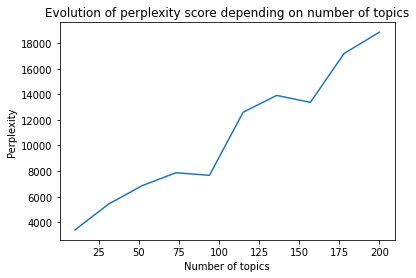

In [ ]:
# lda(X_train, X_test)

In [54]:
n_topics = 100
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0).fit(X)


In [55]:

def Recommend_tags_lda(text):
    
    ''' Recomendation system for stackoverflow posts based on a lda model, 
    it returns up to 5 tags.
    Parameters:
    text: the stackoverflow post of user
    '''
    
    threshold = 0.010
    list_scores = []
    list_words = []
    used = set()

    text_projection = lda_model.transform(vectorizer.transform(text))
    feature_names = vectorizer.get_feature_names()
    lda_components = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(lda_components[topic].argsort()[:-5:-1], sorted(lda_components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    unique_results = [x for x in results if x not in used] # get only unique tags
    tags = " ".join(results[:5])

    return tags

In [56]:
text = np.array('tavascript and java which are not compatible language despite their close names. Python is probably a better approach'.split())
Recommend_tags_lda(text)

text = np.array('Python is probably a better approach'.split())
Recommend_tags_lda(text)

text = np.array("I can't use a global API ".split())
Recommend_tags_lda(text)

mlb_t.transform(Recommend_tags_lda(text))



''

'command install python script'

''

array([], shape=(0, 200), dtype=int64)

### Scoring

In [57]:
y_true = mlb_t.transform(docs_tags[:500]).tolist()
y_pred = mlb_t.transform([Recommend_tags_lda(doc) for doc in docs_reduced_body[:500]]).tolist()

In [58]:
scoring(y_true, y_pred)

accuracy: 0.01
precision: 0.0
recall: 0.0
f1-score: 0.0


## Supervised Classifier Model

### Supervised classifier - BoW + LogisticRegression

In [59]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

# TODO WIP
# clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10), n_jobs=30).fit(X_train, y_train)

In [60]:

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

LOGISTIC_REGRESSION_PARAMETERS = {'C': 0.1, 'max_iter': 100, 'n_jobs': -1}
clf = OneVsRestClassifier(LogisticRegression(**LOGISTIC_REGRESSION_PARAMETERS)).fit(X_train, y_train)

# todo faire un grid search cv


In [61]:
with open('classifier', 'wb') as v :
    pickle.dump(clf, v)

In [62]:
def predict_clf(doc: str, classifier=clf) -> list[str]:
    pred = [' '.join(pred) for pred in mlb_t.inverse_transform(classifier.predict(cv.transform(doc.split())))]
    return list(filter(None, pred))

predict_clf('java or kotlin are the best language after python, ftw !')

['java', 'python']

In [63]:
predictions = clf.predict(X_test)
predictions


pred = predictions[1].reshape(1, -1)
# need to reshape prediction to have a matrix of 1 sample with n classes
mlb_t.inverse_transform(pred.reshape(1, -1))


cv.inverse_transform(X_test[1])
mlb_t.inverse_transform(y_test[1].reshape(1, -1))

# all the 
mlb_t.inverse_transform(predictions)
mlb_t.inverse_transform(np.array(y_test))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

[()]

[array(['written', 'would', 'web', 'way', 'twitter', 'three', 'seems',
        'project', 'place', 'original', 'nt', 'look', 'like', 'however',
        'get', 'first', 'done', 'directive', 'cover', 'combine', 'code',
        'called', 'bootstrap', 'best', 'app', 'another', 'angularjs',
        'angular'], dtype='<U22')]

[('angularjs', 'javascript', 'twitter-bootstrap')]

[(),
 (),
 (),
 (),
 (),
 ('java',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('android',),
 (),
 (),
 (),
 ('php',),
 (),
 (),
 ('python',),
 (),
 (),
 (),
 (),
 ('ios',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('android',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('ios',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('swift',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('javascript',),
 (),
 (),
 (),
 (),
 ('arrays',),
 (),
 (),
 (),
 ('java',),
 (),
 (),
 (),
 ('python',),
 (),
 ('java',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('c++',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('python',),
 ('ios', 'xcode'),
 (),

[('c++', 'hash'),
 ('angularjs', 'javascript', 'twitter-bootstrap'),
 ('algorithm', 'android'),
 ('java', 'spring', 'spring-boot', 'spring-mvc', 'tomcat'),
 ('assembly',),
 ('java', 'maven', 'spring', 'spring-boot'),
 ('google-chrome', 'javascript'),
 ('flutter',),
 ('ajax', 'authentication', 'ruby-on-rails'),
 ('.net', 'c#', 'events', 'lambda'),
 ('c#',),
 ('ios', 'iphone', 'ssl'),
 ('java', 'multithreading'),
 ('ruby', 'ruby-on-rails', 'ubuntu'),
 ('image-processing', 'ios', 'iphone'),
 ('ios', 'swift', 'uitableview'),
 ('ios', 'iphone', 'multithreading'),
 ('installation', 'sql-server'),
 ('c++', 'c++11', 'stl'),
 ('.net', 'wpf', 'xaml'),
 ('android',),
 ('css', 'html', 'javascript'),
 (),
 ('android', 'api', 'java'),
 ('css', 'javascript', 'jquery'),
 ('git', 'github', 'ruby-on-rails'),
 ('ios', 'iphone', 'objective-c'),
 ('animation', 'css', 'html', 'javascript', 'jquery'),
 (),
 ('android',),
 ('java',),
 ('cocoa', 'iphone', 'objective-c', 'uiview'),
 ('command-line', 'linux', 's

In [64]:
def predict_supervised(doc):
    """
    Considers doc is already tokenized

    requires classifier
    requires multibinary transformer
    """
    prediction = clf.predict(doc)
    return mlb_t.inverse_transform(prediction.reshape(1, -1))

### Scoring

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import multilabel_confusion_matrix

y_true = np.array(y_test)
y_pred = predictions


In [66]:

scoring(y_true, y_pred)

accuracy: 0.04
precision: 0.11
recall: 0.01
f1-score: 0.01


## Embeddings with Word2Vect

In [67]:
# snippet taken from sample notebook
import gensim
import multiprocessing
from gensim.models import Word2Vec

MAX_TAGS = 200

# sentences = [ docs.split() for docs in docs.reduced_body]
sentences = [ docs.split() for docs in common_words]

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(sentences, min_count=1,vector_size=MAX_TAGS, workers=multiprocessing.cpu_count())
# w2v_model.build_vocab(sentences)
# w2v_model.train(sentences, total_examples=1, epochs=1)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2066
Word2Vec trained


In [68]:
with open('w2v_model', 'wb') as v :
    # pickle.dump(w2v_model, v)
    w2v_model.save(v)


### Averaged vector for documents

#### Manual Averaging

In [69]:
# compute average vector for each document - OLD MANUAL method
averaged_docs = [np.mean([w2v_model.wv[word] for word in doc.split()], axis=0) for doc in docs_reduced_body_sentences ]

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import linear_kernel

def infer_doc_vector(doc):
    return np.mean([w2v_model.wv[word] for word in doc.split()], axis=0)

def most_similar(sentence_vector):
    cosines = []
    for avg_doc in averaged_docs:
        similarity = cosine_similarity(
                sentence_vector.reshape(1, -1),
                avg_doc.reshape(1, -1)
                )
        # print(f'found similarity: {similarity}')
        cosines.append(similarity)
        # returns the index of averaged_docs wichi is the most similar to given document vector
    return np.argsort([ cos[0][0] for cos in cosines])[-1]
    


In [71]:
# tests
index = 789

assert np.array_equal(
    infer_doc_vector(docs_reduced_body_sentences[index]), 
    averaged_docs[index]
    )

assert most_similar(
    infer_doc_vector(docs_reduced_body_sentences[index])
) == index


assert most_similar(
    infer_doc_vector(docs_reduced_body_sentences[index])
) != index+1

#### Gensim's Doc2Vect

In [72]:
# document vectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

VECTOR_SIZE = 50

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs_reduced_body_sentences)]
d2v_model = Doc2Vec(documents, vector_size=VECTOR_SIZE, window=2, min_count=1, workers=multiprocessing.cpu_count())

### Clusterize embeded documents from doc2Vect

#### Kmeans clustering

In [138]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans


X = d2v_model.dv.vectors[:2000]

# TODO this lib is buggy with this version

# visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,10))
# visualizer.fit(X)
# visualizer.show()

# elbow_score = visualizer.elbow_value_

In [176]:

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

N_CLUSTER = 10


d2v_kmeans = MiniBatchKMeans(n_clusters=N_CLUSTER, random_state=0, batch_size=6).fit(X)
d2v_kmeans = KMeans(n_clusters=N_CLUSTER, random_state=0).fit(X)

In [177]:
from sklearn.decomposition import PCA

labels=d2v_kmeans.labels_.tolist()
l = d2v_kmeans.fit_predict(X)
pca = PCA(n_components=2).fit(X)



<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

Text(0.5, 1.0, 'Représentation des documents, des clusters et des centroïdes')

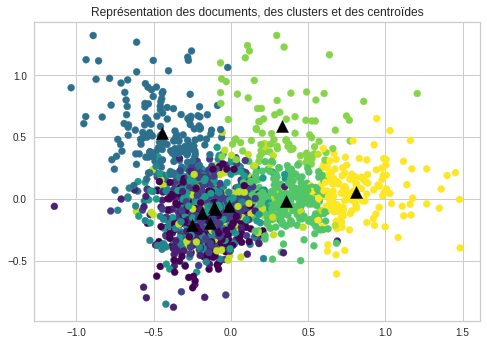

In [178]:

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 12)

datapoint = pca.transform(X)
plt.figure

label1 = viridis(np.linspace(0, 1, N_CLUSTER))
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = d2v_kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.title('Représentation des documents, des clusters et des centroïdes')
plt.show()

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=10, random_state=0))

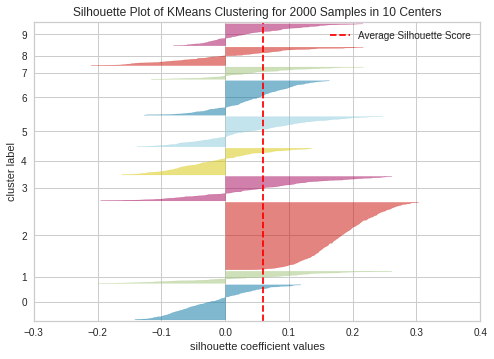

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2000 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [179]:
from yellowbrick.cluster import SilhouetteVisualizer

silouhette_visualizer = SilhouetteVisualizer(d2v_kmeans, colors='yellowbrick')
silouhette_visualizer.fit(X)
silouhette_visualizer.show()

In [548]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def plot_tsne(X_tsne, title="Documents"):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], loc="best", title=title)
    plt.title(f'Représentation des {title}')
    plt.show()


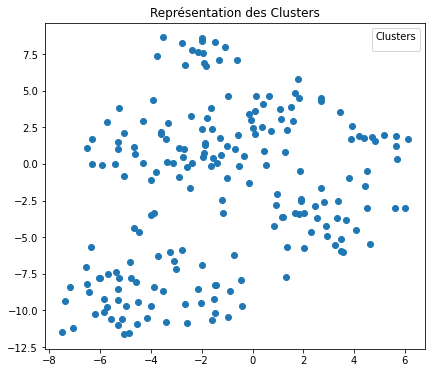

In [549]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_ts = tsne.fit_transform(d2v_kmeans.cluster_centers_)
plot_tsne(X_ts, 'Clusters')

In [149]:
def show_cluster_terms(model, kmeans):
    """
    :param model: model.wv or model.dv
    :return:
    """
    print("Most representative terms per cluster (based on centroids):")
    for i in range(N_CLUSTER):
        tokens_per_cluster = ""
        most_representative = model.most_similar(positive=[kmeans.cluster_centers_[i]], topn=1)
        for t in most_representative:
            tokens_per_cluster += f"{docs_tags[t[0]]} "
        print(f"Cluster {i}: {tokens_per_cluster}")

def get_cluster_tags(cluster_index, model, cluster_model):
    tokens_per_cluster = ""
    most_representative = model.most_similar(positive=[cluster_model.cluster_centers_[cluster_index]], topn=1)
    for t in most_representative:
        tokens_per_cluster += f"{docs_tags[t[0]]}"
    return tokens_per_cluster

In [150]:
show_cluster_terms(d2v_model.dv, d2v_kmeans)

Most representative terms per cluster (based on centroids):
Cluster 0: ['python', 'python-3.x', 'object'] 
Cluster 1: ['php', 'mysql', 'bash', 'terminal'] 
Cluster 2: ['java', 'android'] 


In [577]:
# predict
d2v_kmeans.predict(d2v_model.dv.vectors.astype('double')[5].reshape(1, -1))
get_cluster_tags(24, d2v_model.dv, d2v_kmeans)

vector = d2v_model.infer_vector(['python', 'java', 'pipo'])
d2v_kmeans.predict(vector.astype('double').reshape(1, -1))
# todo : kmeans always returns predicted cluster 174 !

get_cluster_tags(174, d2v_model.dv, d2v_kmeans)

array([24], dtype=int32)

"['iphone', 'ios', 'ipad']"

array([174], dtype=int32)

"['java', 'exception']"

#### OneVsRest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = d2v_model.dv.vectors
y = docs_tags_mlb

pca = PCA(n_components=0.8)
pca.fit(X)
print(pca.explained_variance_ratio_)
X = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

PCA(n_components=0.8)

[0.19171308 0.12240946 0.08712712 0.06982937 0.06154359 0.05843225
 0.05352506 0.0445902  0.03787078 0.03155191 0.02849644 0.02725515]


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

LOGISTIC_REGRESSION_PARAMETERS = { 
    'C' : 0.1,
    'max_iter': 100,
    }

clf_w2v = OneVsRestClassifier(LogisticRegression(**LOGISTIC_REGRESSION_PARAMETERS), n_jobs = -1).fit(X_train, y_train)
# clf_w2v = OneVsRestClassifier(LinearSVC()).fit(X_train, y_train)



In [ ]:
clf_w2v.multilabel_

True

In [ ]:
y_train[2]
clf_w2v.predict([X_train[2]])


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

array([[   0,  558],
       [   1, 3551],
       [   2, 6288],
       [   3, 5600],
       [   4, 2488],
       [   5,  504]])

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Multiple tags per document')

Text(0, 0.5, '# of Occurrences')

Text(0.5, 0, '# of tags')

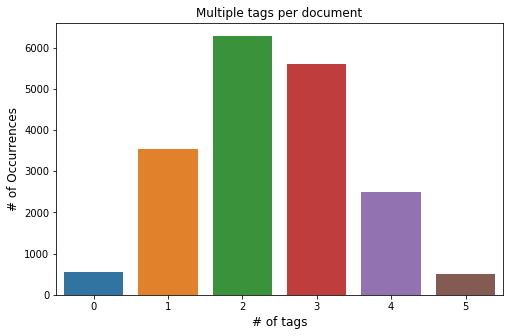

In [ ]:
import seaborn as sns

sums = np.array(y_train).sum(axis=1)
unique, counts = np.unique(sums, return_counts=True)
np.asarray((unique, counts)).T


#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(unique, counts)
plt.title("Multiple tags per document")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags', fontsize=12)


In [ ]:

X_train[:5]

array([[-0.10910334, -0.07513558,  0.10972441,  0.25919098,  0.11152152,
        -0.11182533, -0.01210447,  0.25762063, -0.24372551,  0.10148508,
         0.10846823,  0.00666576,  0.17511316, -0.01357325,  0.04835843,
         0.15837076, -0.05681456, -0.3916358 , -0.1676209 , -0.19269866,
        -0.00292315,  0.07029635,  0.19962692, -0.00756755, -0.03009229,
        -0.09856486,  0.20625104, -0.24052861,  0.10727967,  0.21483903,
         0.3067191 ,  0.0149092 ,  0.16102585,  0.05942419,  0.01051321,
         0.09097548,  0.32030302,  0.17578658,  0.12838611,  0.0960753 ,
         0.02305324, -0.01479684, -0.36821672,  0.02836213, -0.25730208,
        -0.25273895,  0.17715113,  0.20365012,  0.1345254 ,  0.187125  ],
       [ 0.0989326 , -0.01012205,  0.1989014 ,  0.19691487,  0.15766433,
         0.2361593 , -0.0731945 ,  0.0397863 , -0.08064657,  0.17544577,
        -0.20619825, -0.02678109,  0.2464381 ,  0.00902164, -0.16439247,
        -0.28444877, -0.1580462 ,  0.24643432, -0.

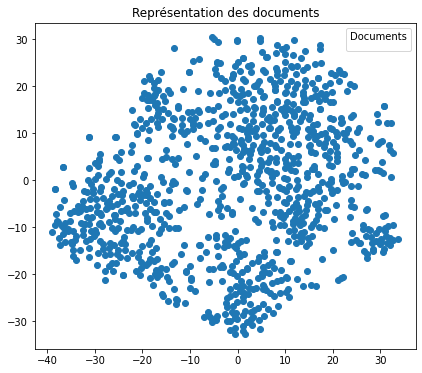

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
# X_ts = tsne.fit_transform(d2v_kmeans.cluster_centers_)
X_ts = tsne.fit_transform(X[:1000])
plot_tsne(X_ts)


## Embedding with BERT

In [139]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

# TODO WIP

2022-05-18 23:40:50.297463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 23:40:50.297490: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-18 23:41:03.852566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 23:41:03.852603: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 23:41:03.852646: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rocketstation): /proc/driver/nvidia/version does not exist
2022-05-18 23:41:03.853521: I tensorflow/core/platform/cpu_feat

## Embedding with USE

<https://tfhub.dev/google/universal-sentence-encoder/4>

In [350]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
     "The quick brown fox jumps over the lazy dog.",
     "I am a sentence for which I would like to get its embedding"])

print(embeddings)

# The following are example embedding output of 512 dimensions per sentence
# Embedding for: The quick brown fox jumps over the lazy dog.
# [-0.03133016 -0.06338634 -0.01607501, ...]
# Embedding for: I am a sentence for which I would like to get its embedding.
# [0.05080863 -0.0165243   0.01573782, ...]


tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [351]:
embedding_sentences_use = embed(docs_reduced_body_sentences)

2022-05-18 16:29:46.219317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3863912960 exceeds 10% of free system memory.


In [354]:
embedding_sentences_use[:10]

<tf.Tensor: shape=(10, 512), dtype=float32, numpy=
array([[-0.05029071, -0.08394418,  0.00878896, ...,  0.04465757,
         0.03081728, -0.01319525],
       [-0.05983222, -0.06448191, -0.04054492, ...,  0.00205396,
        -0.02818006, -0.06186812],
       [ 0.00371305, -0.05495844,  0.06492435, ...,  0.06593531,
         0.04449611,  0.01073632],
       ...,
       [-0.06462792, -0.0718297 , -0.07106666, ...,  0.04554954,
        -0.03202449, -0.05778236],
       [ 0.02097749,  0.05813687, -0.06637868, ...,  0.05400171,
         0.00604719,  0.01832996],
       [-0.02686183, -0.05730646,  0.04412023, ...,  0.07308202,
         0.04375282, -0.02184503]], dtype=float32)>

In [426]:

X = embedding_sentences_use.numpy()
y = docs_tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
clf_use = OneVsRestClassifier(LogisticRegression(**LOGISTIC_REGRESSION_PARAMETERS)).fit(X_train, y_train)

In [435]:
clf_use.predict(embed('java or kotlin are the best language after python, ftw !'.split()).numpy())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [429]:
def predict_clf_use(docs: str) -> list[str]:
    pred = [clf_use.predict(text.reshape(1, -1))[0] for text in docs]
    # return list(filter(None, pred))
    return pred

predict_clf_use([embed(['java or kotlin are the best language after python, ftw !']).numpy()])


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])]

In [430]:
y_true = np.array(y_test)
y_true[:2]
y_pred = predict_clf_use(X_test)
y_pred[:2]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [425]:
scoring(y_true, y_pred)

accuracy: 0.02
precision: 0.0
recall: 0.0
f1-score: 0.0


## Appendix

sample:

<https://www.analyticsvidhya.com/blog/2021/09/onevsrest-classifier-for-predicting-multiple-tags-of-research-articles/#h2_2>



à lire


topic modelling : unsupervised learning

topic classification : supervised learning


<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/>

<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

<https://medium.com/le-blog-de-lapprentissage-automatique/pr%C3%A9diction-des-tags-des-questions-de-stack-overflow-9be00f7672f9>

Topic Modeling: Predicting Multiple Tags of Research Articles using OneVsRest strategy:

<https://www.analyticsvidhya.com/blog/2021/09/onevsrest-classifier-for-predicting-multiple-tags-of-research-articles/#h2_2>

Baeldung: Topic Modeling with Word2Vec

<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

Evaluating Multi-label Classifiers

<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>


Difference stemming lemmatization

<https://fr.quora.com/Quelle-est-la-diff%C3%A9rence-entre-le-stemming-et-la-lemmatisation>

Multi Label scoring

<https://medium.datadriveninvestor.com/predicting-tags-for-the-questions-in-stack-overflow-29438367261e>
<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>


NLP : une classification multilabels simple, efficace et interprétable

<https://blog.octo.com/nlp-une-classification-multilabels-simple-efficace-et-interpretable/>


Part 2: Topic Modeling and Latent Dirichlet Allocation (LDA) using Gensim and Sklearn

<https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/#:~:text=Latent%20Dirichlet%20Allocation%20(LDA)%20is,are%20also%20%E2%80%9Chidden%20topics%E2%80%9D.>


Part 3: Topic Modeling and Latent Dirichlet Allocation (LDA) using Gensim and Sklearn

<https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/>


Most probably the closest tutorial available: <https://towardsdatascience.com/tags-recommendation-algorithm-using-latent-dirichlet-allocation-lda-3f844abf99d7>